# **AP157 Module C Lab Assignment**

## Module C2: Monte Carlo Methods

_Instructions_: Answer each part of the assignment as completely as you can. Discuss **all** your code and results as clearly and concisely as possible.

_Scoring Criteria_: 50% - *correctness of code*; 50% - *discussion of the code and results*. Maximum score is **100 points**.

_Credits_: This lab assignment is based on work by Dr. Reyes in collaboration with Gene Belinario and Dr. Reginald Bernardo.

### Student Information

_Full Name (Last Name, First Name)_: Clemente, Lance\
_Student No._: 2021-07811\
_Section_: TX-1

### Submission Information

_Date and Time Submitted (most recent upload)_: May 25, 2024, 1:45 AM

**HONOR PLEDGE** I affirm that I have upheld the highest principles of honesty and integrity in my academic work and that this lab assignment is my own work.

**Sign here with your full name: Lance Clemente**

### Grading Information (c/o Instructor)

TOTAL SCORE: **[]**/100

Score breakdown:
* Part 1 - []/20
* Part 2 - []/20
* Part 3 - []/30
* Part 4 - []/30

_Date and Time Scored (MM/DD/YYYY HH:MM AM/PM):_

In this lab assignment, you will generate constraints on cosmological parameters, the Hubble parameter H_0 and matter density Omega_m,0, from (synthetic) Hubble diagram data points from gravitational-wave (GW) sirens observed from 3 GW observatories: LIGO, LISA, and Einstein Telescope (ET).

The datasets are in the Google Drive "Datasets" Folder under "AP157_moduleC2" subfolder: https://drive.google.com/drive/folders/1UnK1AggxdsjtG3PoOcyXfpahBcWjOBzj?usp=drive_link.

Read in the 3 datasets from the CSV files: LIGO.csv, LISA.csv, ET.csv. The columns are redshift (z), luminosity distance (dL), and error in the luminosity distance (err). The distances are in units of Gpc (giga-parsecs).

Load the data into variable names: zLIGO, dLLIGO, errLIGO, zLISA, dLLISA, errLISA, and zET, dLET, and errET, respectively. Note that these variable names will be used in later parts of the code, so you have to use these names for compatibility.

In [23]:
from google.colab import drive
drive.mount("/content/drive")
file_path = "/content/drive/My Drive/AP157/AP157_moduleC2/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import minimize

In [25]:
ligo = file_path+'LIGO.csv'
lisa = file_path+'LISA.csv'
et = file_path+'ET.csv'

ligo_data = pd.read_csv(ligo)
zLIGO = ligo_data['zLIGO'].values
dlLIGO = ligo_data['dlLIGO'].values
errLIGO = ligo_data['errLIGO'].values

lisa_data = pd.read_csv(lisa)
zLISA = lisa_data['zLISA'].values
dlLISA = lisa_data['dlLISA'].values
errLISA = lisa_data['errLISA'].values

et_data = pd.read_csv(et)
zET = et_data['zET'].values
dlET = et_data['dlET'].values
errET = et_data['errET'].values


By the end of the lab assignment, you will generate constraints on the cosmological parameters H_0 and omega_m,0 for 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET (combined). You will generate a corner plot to visualize these constraints similar to the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

#### PART 1 - Generate Hubble Diagram *(20 points)*

Make a Hubble diagram plot-- with luminosity distance (d_L) in the vertical axis and redshift (z) in the horizontal axis. Show the errors in d_L as error bars.

Plot GW sirens from the 3 observatories in the same plot and include a legend. Briefly describe the difference between the samples from the 3 observatories.

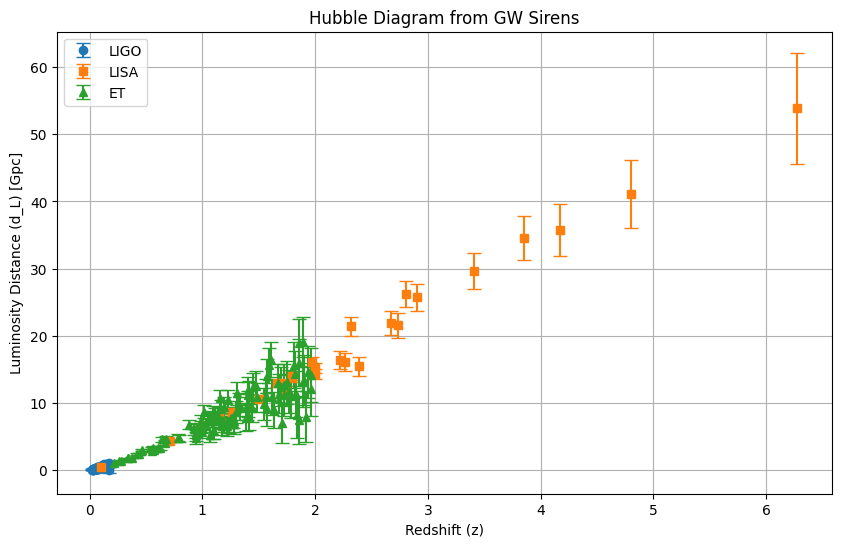

In [ ]:
plt.figure(figsize=(10, 6))

plt.errorbar(zLIGO, dlLIGO, yerr=errLIGO, fmt='o', label='LIGO', capsize=5)
plt.errorbar(zLISA, dlLISA, yerr=errLISA, fmt='s', label='LISA', capsize=5)
plt.errorbar(zET, dlET, yerr=errET, fmt='^', label='ET', capsize=5)

#plot details
plt.xlabel('Redshift (z)')
plt.ylabel('Luminosity Distance (d_L) [Gpc]')
plt.title('Hubble Diagram from GW Sirens')
plt.legend()
plt.grid(True)
plt.show()


LIGO data points have small luminosity distances and low redshifts. It has a small and sensitive range. LISA data points have higher and larger luminosity distances and redshifts than LIGO. Can detect at events at higher redshifts. ET data points can detect at much farther redshifts, but still can detect at redshifts similar to LIGO.

#### PART 2 - Define likelihood functions *(20 points)*

In this analysis, we will assume the cosmological model to be flat LambdaCDM universe. This is given by the `FlatLambdaCDM' model from the astropy.cosmology package. In particular, we use the model for the luminosity distance as a function of redshift, which is encoded in the luminosity_distance function.

Below, define the chi-square and likelihood function to be used for the LIGO only and the LIGO+LISA dataset. You are asked to define the analogous functions for the LIGO+LISA+ET dataset. Note that the likelihood for the combined dataset is simply the sum of the likelihoods for the individual datasets.




In [ ]:
from astropy.cosmology import FlatLambdaCDM

In [45]:
def chi2LIGO_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)      # define cosmological model
    model = np.array(cosmo.luminosity_distance(zLIGO)/1000) # converted from Gpc to Mpc units
    dev = (model - np.array(dlLIGO))/np.array(errLIGO)      # deviations between model and data
    chi2 = sum(dev**2)
    return chi2

def llikeLIGO_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0):
        return -np.inf                        # return inf if outside priors
    else:
        return -0.5*chi2LIGO_lcdm(H0, Om0)

# LIGO + LISA
def chi2LISA_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
    model = np.array(cosmo.luminosity_distance(zLISA)/1000)
    dev = (model - np.array(dlLISA))/np.array(errLISA)
    chi2 = sum(dev**2)
    return chi2

def llikeLIGOLISA_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0):
        return -np.inf
    else:
        return -0.5*(chi2LIGO_lcdm(H0, Om0) + chi2LISA_lcdm(H0, Om0))

# LIGO + LISA + ET
def chi2ET_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
    model = np.array(cosmo.luminosity_distance(zET)/1000)
    dev = (model - np.array(dlET))/np.array(errET)
    chi2 = sum(dev**2)
    return chi2

def llikeLIGOLISAET_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0):
        return -np.inf
    else:
        return -0.5*(chi2LIGO_lcdm(H0, Om0) + chi2LISA_lcdm(H0, Om0) \
                     + chi2ET_lcdm(H0, Om0))

#### PART 3 - Perform MCMC runs *(30 points)*

Use the emcee library to set up and perform MCMC runs for the 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET combined.

You can try the ff. parameters-- number of walkers (nwalkers) of 100 and number of iterations (niter) of 1,000 and number of burn-in samples (nburn) of 100.

Note that the number of dimensions (ndim) is the number of parameters, equal to 2.

For the methodology of stepping from one place of the grid to another, you can use:

    dres = [0.1, 0.003] # step size for H_0 and omega_m,0, respectively
    pos0 = [result + dres * np.random.randn(ndim) for i in range(nwalkers)]

In [40]:
pip install emcee

100%|██████████| 1000/1000 [10:44<00:00,  1.55it/s]


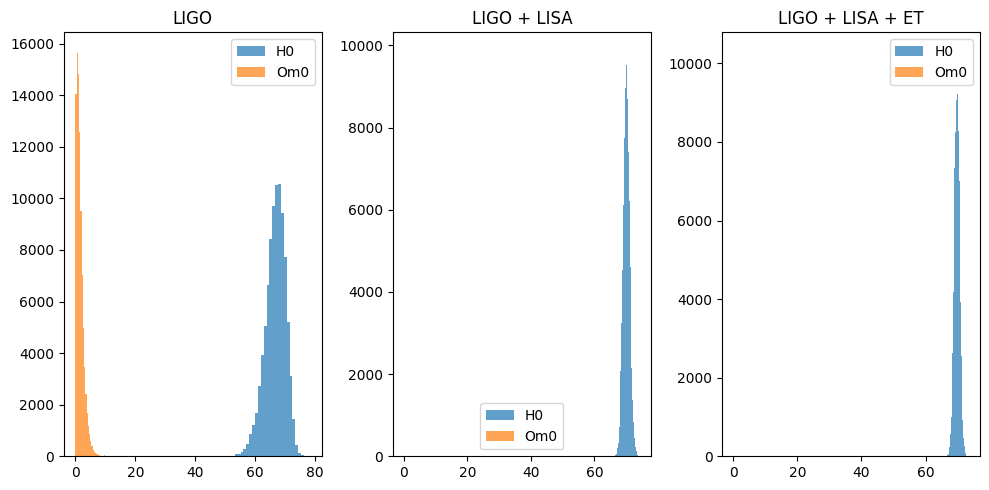

In [46]:
import emcee

def log_prob_ligo(params):
    H0, Om0 = params
    return llikeLIGO_lcdm(H0, Om0)

def log_prob_ligolisa(params):
    H0, Om0 = params
    return llikeLIGOLISA_lcdm(H0, Om0)

def log_prob_ligolisaet(params):
    H0, Om0 = params
    return llikeLIGOLISAET_lcdm(H0, Om0)

ndim = 2
nwalkers = 100
niter = 1000
nburn = 100

dres = [0.1, 0.003]

np.random.seed(42)
pos0_ligo = [np.array([70, 0.3]) + dres * np.random.randn(ndim) for i in range(nwalkers)]
pos0_ligolisa = [np.array([70, 0.3]) + dres * np.random.randn(ndim) for i in range(nwalkers)]
pos0_ligolisaet = [np.array([70, 0.3]) + dres * np.random.randn(ndim) for i in range(nwalkers)]

# MCMC for LIGO only
sampler_ligo = emcee.EnsembleSampler(nwalkers, ndim, log_prob_ligo)
sampler_ligo.run_mcmc(pos0_ligo, niter, progress=True)

# MCMC for LIGO+LISA
sampler_ligolisa = emcee.EnsembleSampler(nwalkers, ndim, log_prob_ligolisa)
sampler_ligolisa.run_mcmc(pos0_ligolisa, niter, progress=True)

# MCMC for LIGO+LISA+ET
sampler_ligolisaet = emcee.EnsembleSampler(nwalkers, ndim, log_prob_ligolisaet)
sampler_ligolisaet.run_mcmc(pos0_ligolisaet, niter, progress=True)

samples_ligo = sampler_ligo.get_chain(discard=nburn, flat=True)
samples_ligolisa = sampler_ligolisa.get_chain(discard=nburn, flat=True)
samples_ligolisaet = sampler_ligolisaet.get_chain(discard=nburn, flat=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.hist(samples_ligo[:, 0], bins=30, alpha=0.7, label='H0')
plt.hist(samples_ligo[:, 1], bins=30, alpha=0.7, label='Om0')
plt.legend()
plt.title("LIGO")

plt.subplot(1, 3, 2)
plt.hist(samples_ligolisa[:, 0], bins=30, alpha=0.7, label='H0')
plt.hist(samples_ligolisa[:, 1], bins=30, alpha=0.7, label='Om0')
plt.legend()
plt.title("LIGO + LISA")

plt.subplot(1, 3, 3)
plt.hist(samples_ligolisaet[:, 0], bins=30, alpha=0.7, label='H0')
plt.hist(samples_ligolisaet[:, 1], bins=30, alpha=0.7, label='Om0')
plt.legend()
plt.title("LIGO + LISA + ET")

plt.tight_layout()
plt.show()

#### PART 4 - Generate corner plot to visualize the constraints *(30 points)*

Overlay the results for the 3 samples for easy comparison. Your plot should resemble the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

Briefly describe the difference between the constraints obtained from the different samples.

In [48]:
pip install corner

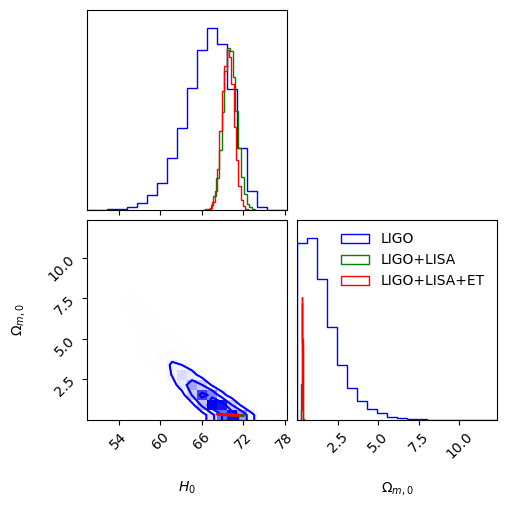

In [47]:
import corner

fig = corner.corner(samples_ligo, labels=["$H_0$", "$\Omega_{m,0}$"],
                    plot_contours=True, plot_datapoints=False, color='blue', alpha=0.5)
corner.corner(samples_ligolisa, labels=["$H_0$", "$\Omega_{m,0}$"],
              plot_contours=True, plot_datapoints=False, fig=fig, color='green', alpha=0.5)
corner.corner(samples_ligolisaet, labels=["$H_0$", "$\Omega_{m,0}$"],
              plot_contours=True, plot_datapoints=False, fig=fig, color='red', alpha=0.5)

plt.legend(["LIGO", "LIGO+LISA", "LIGO+LISA+ET"], loc="upper right", frameon=False)

plt.show()

Plots do not resemble the sample shown in sample. LIGO looks odd in the lower left plot. Takeaway from this is that cannot constraint same as the LIGO and ET.